Download the data from: https://www.kaggle.com/uwrfkaggler/ravdess-emotional-speech-audio

### Objectives

**General**: Implement, compare and enhance the performance for a multiclass classification problem. 

**Specific**: Compare the performance between big and small models by using ML techniques. 

### First Part: Audio Preprocessing and Feature Extraction

In [1]:
# Audio Library
import librosa
# Linear Algebra
import numpy as np
# Handling Paths
import os
# Plots
import matplotlib.pyplot as plt
import librosa.display
# Time
import time
# sklearn
import sklearn

Get the root path inside the container

In [2]:
root_path = os.getcwd()
print(root_path)

/home/src


Data path

In [3]:
data_path = '/data'

Calling audio names inside the ```data``` directory 

In [4]:
def calling_audios(data_path):
    '''
        Saving audio names
    '''
    names = list()
    for dirname, _, filenames in os.walk(root_path + data_path):
        for filename in filenames:
            names.append(filename)
    return names

In [5]:
audio_names = calling_audios(data_path)

# Audio Numbers
print("Number of total audios: ")
print(len(audio_names))

print("Name Example: ")
print(audio_names[20])

Number of total audios: 
1440
Name Example: 
03-01-04-01-01-01-01.wav


### Filename identifiers

- Modality (01 = full-AV, 02 = video-only, 03 = audio-only).

- Vocal channel (01 = speech, 02 = song).

- Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

- Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

- Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").

- Repetition (01 = 1st repetition, 02 = 2nd repetition).

- Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

### Extracting MFCCs from audio data

In [6]:
def creating_info_table(path):
    big_model = []
    small_model = []
    big_model_log = []
    small_model_log = []
    audio_lengths = []
    
    start_time = time.time()
    count = 0
    for subdir, dirs, files in os.walk(path):
        for file in files:
            count += 1
            try:
                ##Load librosa array, obtain mfcss, store the file and the mcss information in a new array
                X, sample_rate = librosa.load(os.path.join(subdir,file),duration=3, offset=0.5,res_type='kaiser_fast')
                
                
                # make sure waveform vectors are homogenous by defining explicitly
                waveform_homo = np.zeros((int(sample_rate*3,)))
                waveform_homo[:len(X)] = X
                
                # Model 1 (big)
                mfccs = np.mean(librosa.feature.mfcc(y=waveform_homo, sr=sample_rate, n_mfcc=40).T,axis=0) 
                # Model 2 (small)
                mfccs_small = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=12).T,axis=0) 

                # Model 1 (big log) 
                mfccs_log = np.mean(librosa.power_to_db(librosa.feature.mfcc(y=waveform_homo, sr=sample_rate, n_mfcc=40).T),axis=0) 

                # Model 2 (small log) 
                mfccs_small_log = np.mean(librosa.power_to_db(librosa.feature.mfcc(y=waveform_homo, sr=sample_rate, n_mfcc=12).T),axis=0) 
                
                ## The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
                ## This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
                file = int(file.split("-")[2])
                
                arr = mfccs, file
                arr_small = mfccs_small, file
                arr_log = mfccs_log, file
                arr_small_log = mfccs_small_log, file
                
                big_model.append(arr)
                big_model_log.append(arr_log)
                small_model.append(arr_small)
                small_model_log.append(arr_small_log)
                
                audio_lengths.append(len(waveform_homo))
                
          # If the file is not valid, skip it
            except ValueError:
                continue
    print("Total Number of Audio Files")
    print(count)
    print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))
    
    return big_model, small_model, big_model_log,small_model_log,audio_lengths

#### Removing the hidden file ```.DS_Store```

In [7]:
rm -v /home/src/data/.DS_Store

rm: cannot remove '/home/src/data/.DS_Store': No such file or directory


#### Extracting MFCCs and then calculate the average over time for 40 and 12 feature dimensions. 

In [8]:
big_model, small_model, big_model_log,small_model_log,audio_lengths = creating_info_table(root_path+'/'+data_path)

Total Number of Audio Files
1440
--- Data loaded. Loading time: 102.75753808021545 seconds ---


#### Saving The Feature Vectors (MFCCs) and Class Vector

In [9]:
Xb, yb = zip(*big_model)
Xb = np.asarray(Xb)
yb = np.asarray(yb)

Xs, ys = zip(*small_model)
Xs = np.asarray(Xs)
ys = np.asarray(ys)

Xbl, ybl = zip(*big_model_log)
Xbl = np.asarray(Xbl)
ybl = np.asarray(ybl)

Xsl, ysl = zip(*small_model_log)
Xsl = np.asarray(Xsl)
ysl = np.asarray(ysl)

In [10]:
filename = 'processed_data/mfccs_big_and_small.npy'

# open file in write mode and write data
with open(filename, 'wb') as f:
    np.save(f, Xb)
    np.save(f, yb)
    np.save(f, Xs)
    np.save(f, ys)
    np.save(f, Xbl)
    np.save(f, ybl)
    np.save(f, Xsl)
    np.save(f, ysl)
    
print(f'Features and labels saved to {filename}')

Features and labels saved to processed_data/mfccs_big_and_small.npy


In [11]:
# Check the dimensions of the saved data
print(f'Xb:{Xb.shape}, yb:{yb.shape}')
print(f'Xs:{Xs.shape}, ys:{ys.shape}')
print(f'Xb:{Xbl.shape}, yb:{ybl.shape}')
print(f'Xs:{Xsl.shape}, ys:{ysl.shape}')

Xb:(1440, 40), yb:(1440,)
Xs:(1440, 12), ys:(1440,)
Xb:(1440, 40), yb:(1440,)
Xs:(1440, 12), ys:(1440,)


Checking the saved data

In [12]:
# open file in read mode and read data 
with open(filename, 'rb') as f:
    Xb = np.load(f)
    yb = np.load(f)
    Xs = np.load(f)
    ys = np.load(f)
    Xbl = np.load(f)
    ybl = np.load(f)
    Xsl = np.load(f)
    ysl = np.load(f)
# Check that we've recovered the right data
print(f'Xb:{Xb.shape}, yb:{yb.shape}')
print(f'Xs:{Xs.shape}, ys:{ys.shape}')
print(f'Xb:{Xbl.shape}, yb:{ybl.shape}')
print(f'Xs:{Xsl.shape}, ys:{ysl.shape}')

Xb:(1440, 40), yb:(1440,)
Xs:(1440, 12), ys:(1440,)
Xb:(1440, 40), yb:(1440,)
Xs:(1440, 12), ys:(1440,)


Checking the dimensions

In [13]:
print(np.max(audio_lengths))
print(np.min(audio_lengths))

66150
66150


In [14]:
print("Cantidad de elementos en cada arreglo")
print(len(big_model))
print(len(small_model))
print(len(big_model_log))
print(len(small_model_log))

Cantidad de elementos en cada arreglo
1440
1440
1440
1440


In [15]:
print("MFCCs Dimensions")
print(big_model[0][0].shape)
print(small_model[0][0].shape)
print(big_model_log[0][0].shape)
print(small_model_log[0][0].shape)

MFCCs Dimensions
(40,)
(12,)
(40,)
(12,)


#### Extracting RMS Energy and Zero Crossing Features. First feature associated to average energy into the signal, and second feature associated to the rythm pattern. 

```hop_length```: Number of samples beetween sucessives windows, for example columns of the espectrogram. It is a positive integer. 

```frame_length```: Multiple of the ```hop_length```. It is the size of the window moving across the signal, which takes the ```rms``` sum over the samples.  

In [16]:
def Audio_Energy(x):
    hop_length = 256
    frame_length = 512
    return librosa.feature.rms(x, frame_length=frame_length, hop_length=hop_length, center=True)

In [17]:
def Zero_Crossing(x):
    return librosa.feature.zero_crossing_rate(x)

In [18]:
def Spectral_Centroids(x,sr):
    return librosa.feature.spectral_centroid(x, sr=sr)[0]

In [19]:
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

#### Applying the extraction

In [20]:
def features(path):
    lst = []
    start_time = time.time()
    count = 0
    epsilon = 0.01
    for subdir, dirs, files in os.walk(path):
        for file in files:
            count += 1
            try:
                #Load librosa array obtain rms energy and zero crossing, just pick three seconds and cut off
                # the first 0.5 sec. "kaiser_fast" is used to resample the file as faster as possible. 
                X, sample_rate = librosa.load(os.path.join(subdir,file),duration=3, offset=0.5, res_type='kaiser_fast')
                
                # make sure waveform vectors are homogenous by defining explicitly
                waveform_homo = np.zeros((int(sample_rate*3,)))
                waveform_homo[:len(X)] = X
                
                energy = Audio_Energy(waveform_homo)
                zero_cross =  Zero_Crossing(waveform_homo+epsilon)
                spectral_centroids = Spectral_Centroids(X+epsilon,sample_rate)
                # La lista tiene 3 vectores de caracteristicas por elemento
                arr = energy, zero_cross, spectral_centroids
                lst.append(arr)
          # If the file is not valid, skip it
            except ValueError:
                continue
    print("Total Number of Audio Files")
    print(count)
    print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))
    return lst

In [21]:
rmse_and_zerocross = features(root_path+'/'+data_path)

Total Number of Audio Files
1440
--- Data loaded. Loading time: 68.18746280670166 seconds ---


#### Saving the features

In [22]:
rms_energy, zero_cross, spectral_centroid= zip(*rmse_and_zerocross)

In [23]:
print(np.asarray(rms_energy).shape)
print(np.asarray(zero_cross).shape)
print(np.asarray(spectral_centroid).shape)

(1440, 1, 259)
(1440, 1, 130)
(1440,)


/usr/local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [24]:
rms_energy = np.asarray(rms_energy)
zero_cross = np.asarray(zero_cross)
spectral_centroid = np.asarray(spectral_centroid)

In [25]:
filename = 'processed_data/more_features.npy'
# open file in write mode and write data
with open(filename, 'wb') as f:
    np.save(f, rms_energy)
    np.save(f, zero_cross)
    np.save(f, spectral_centroid )

print(f'Features and labels saved to {filename}')

Features and labels saved to processed_data/more_features.npy


Checking Dimensions

In [26]:
print("Dimensions for each feature: ")
print("Energy: ")
print(rmse_and_zerocross[0][0].shape)
print("Zero Crossing: ")
print(rmse_and_zerocross[0][1].shape)
print("Another Example:")
print("Energy: ")
print(rmse_and_zerocross[7][0].shape)
print("Zero Crossing: ")
print(rmse_and_zerocross[7][1].shape)

Dimensions for each feature: 
Energy: 
(1, 259)
Zero Crossing: 
(1, 130)
Another Example:
Energy: 
(1, 259)
Zero Crossing: 
(1, 130)


### Observando las representaciones de cada feature visualmente

Mel-Spectrogram 

In [27]:
y, sr = librosa.load('/home/src/data/Actor_01/03-01-01-01-01-01-01.wav')

In [28]:
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

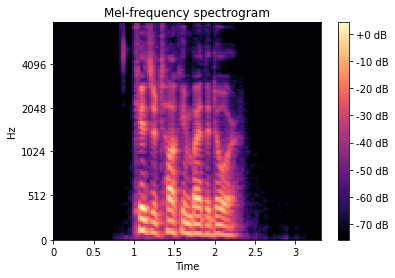

In [29]:
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.power_to_db(mel_spec), x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

Energy, Zero Crossing and Spectral Centroid

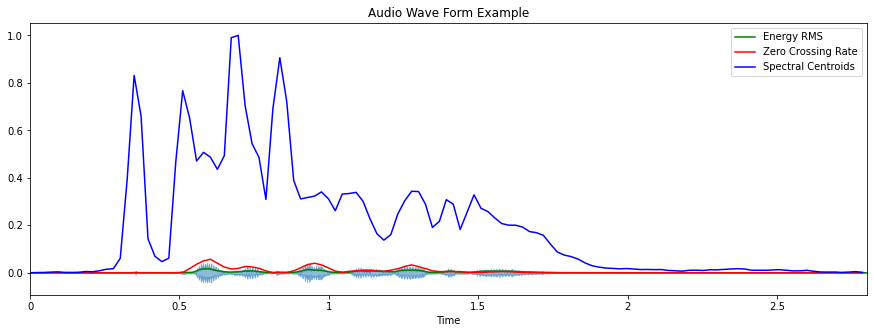

In [30]:
plt.figure(figsize=(15,17))
ax = plt.subplot(3,1,1)

# Audio de ejemplo
X, sample_rate = librosa.load('/home/src/data/Actor_01/03-01-01-01-01-01-01.wav',duration=3, offset=0.5,res_type='kaiser_fast')

# Energia RMS
rms_energy_example = Audio_Energy(X)[0]

# Zero Crossing
zero_crossing_example = Zero_Crossing(X+0.01)[0]

# Spectral Centroid
spectral_centroids = Spectral_Centroids(X+0.01,sample_rate)

# Frames to Time
frames = range(len(rms_energy_example))
t = librosa.frames_to_time(frames, hop_length = 256)
tz = librosa.frames_to_time(range(0,len(zero_crossing_example)))
ts = librosa.frames_to_time(range(0,len(spectral_centroids)))



# Gráficos
librosa.display.waveplot(X,alpha=0.5)
plt.plot(t,rms_energy_example,color = 'g')
plt.plot(tz,zero_crossing_example,color = 'r')
plt.plot(ts, normalize(spectral_centroids), color='b') 
plt.title("Audio Wave Form Example")
plt.legend(["Energy RMS", "Zero Crossing Rate", "Spectral Centroids"], loc ="upper right")


The silence at the beginning and at the end of the file has a base noise of low amplitude, but as a noise, it cross more times the zero value in comparison to a voice. For that reason, we can add up constant term in order to increase the noise ratio, avoiding the zero crossing of the base noise. You can try erasing the ```+0.01```value inside the zero crossing function. The same occurs for spectral centroids (due to noise). 